# Create a spectral plot for Sentinel 2a pixels

**Background** Sentinel 2 data is currently under development and not available for public use as yet. This notebook is working off an internal development instance of DEA, and will form part of the DEA documentation once Sentinel 2 is moved to production.

**What does this notebook do?** This notebook allows you to plot up pixel spectra at the bands' native resolutions. The user loads in some data, then selects a pixel for interrogation using a plot widget. The spectra for this pixel is extracted and plotted. This notebook takes advantage of the different native resolutions of bands from the Sentinel 2 satellite to explore the variability associated with bands being recorded at different spatial resolutions. The code uses the 60m resolution of the `aerosol` band to determine a bounding box for the higher resolution bands. The pixels that fall within that bounding box are selected, and the range of spectral values across the additional pixels are plotted to characterise the spectral heterogeneity of the selected area.

**Date**: May 2018.

**Author**: Claire Krause

## About Sentinel 2 bands

The spatial resolution of Sentinel 2 is dependent on the band, with different bands being collected at 10m, 20m or 60m resolution.

** 10m spatial resolution **
![10m spatial resolution](https://earth.esa.int/image/image_gallery?uuid=c5fa6c3e-2978-4fb8-ac95-3be9c5171be2&groupId=247904&t=1345630320883)

| Sentinel 2 bands | DEA band name | Band number | Central wavelength (nm) | Resolution (m) | Bandwidth (nm) |
| -----------------|---------------|-------------|-------------------------|----------------|----------------|
| Blue | `blue` | 2 | 490 | 10 | 65 |
| Green | `green` | 3 | 560 | 10 | 35 |
| Red | `red` | 4 | 665 | 10 | 30 |
| NIR | `nir1` | 8 | 842 | 10 | 115 |

** 20m spatial resolution **
![20m spatial resolution](https://earth.esa.int/image/image_gallery?uuid=15dad96b-be6a-4b04-931d-d8c4db39e9e2&groupId=247904&t=1345630328076)

| Sentinel 2 bands | DEA band name | Band number | Central wavelength (nm) | Resolution (m) | Bandwidth (nm) |
| -----------------|---------------|-------------|-------------------------|----------------|----------------|
| Vegetation red edge | `rededge1` | 5 | 705 | 20 | 15 |
| Vegetation red edge | `rededge2` | 6 | 740 | 20 | 15 |
| Vegetation red edge | `rededge3` | 7 | 783 | 20 | 20 |
| Narrow NIR | `nir2` | 8A | 865 | 20 | 20 |
| SWIR | `swir1` | 11 | 1610 | 20 | 90 |
| SWIR | `swir2` | 12 | 2190 | 20 | 180 |

** 60m spatial resolution **
![60m spatial resolution](https://earth.esa.int/image/image_gallery?uuid=f6117fbe-1513-4a84-acc4-845e14e5c876&groupId=247904&t=1345630315020)

| Sentinel 2 bands | DEA band name | Band number | Central wavelength (nm) | Resolution (m) | Bandwidth (nm) |
| -----------------|---------------|-------------|-------------------------|----------------|----------------|
| Coastal aerosol | `aerosol` | 1 | 443 | 60 | 20 |
N.B. Bands 9 and 10 are not available within DEA

## Import the required libraries

In [1]:
%pylab notebook

from datacube import Datacube

# Import widgets for interactive notebook
from ipywidgets import interact, fixed
import ipywidgets as widgets

# Import the custom script for plotting. This script can be found in the dea-notebooks repository.
import sys
import os.path
sys.path.append(os.path.expanduser('~/dea-notebooks/Scripts'))
import DEAPlotting

# The path to the Sentinel 2 development DEA instance configuration file
s2dc = Datacube(config=(os.path.expanduser('~/Sentinel2_datacube.conf')))

Populating the interactive namespace from numpy and matplotlib


## Define a function that does all of the work 

We are putting this all into a single widget function so that once a pixel is selected, the user does not need to run additional cells to get to the desired outputs

In [2]:
def onclick(event):
    '''
    This function performs all of the work in this notebook. We have put all of the
    processing within this function so that all the calculations are done following
    a 'click' and therefore do not need to be in separate cells. This makes the notebook
    smoother and minimises the cells that need to be manually run by the user once a 
    location has been selected. 

    This particular widget function uses the selected to location to plot two images:
    - spectra for the pixel closest to the chosen location
    - spectra for the pixel/s closest to the chosen location using the 60m pixel as
    a bounding box for the higher resolution pixels.
    These two images are run in the subsequent cells.
    '''
    global pixelx, pixely, spectra, spectramin, spectramax, spectramean
    pixelx, pixely = int(event.xdata), int(event.ydata)
    w.value = 'pixelx : {}, pixely : {}'.format(pixelx, pixely)
    plt.plot(pixelx, pixely, 'ro', markersize=5)

    # Find the pixel closest to the chosen pixel at each resolution
    Pixel10m = Resolution10m.sel(y=pixely, x=pixelx, method='nearest')
    Pixel20m = Resolution20m.sel(y=pixely, x=pixelx, method='nearest')
    Pixel60m = Resolution60m.sel(y=pixely, x=pixelx, method='nearest')

    # Grab the pixel spectral values for each band
    spectra = [Pixel60m.aerosol.isel(time=mytime).values,
               Pixel10m.blue.isel(time=mytime).values,
               Pixel10m.green.isel(time=mytime).values,
               Pixel10m.red.isel(time=mytime).values,
               Pixel20m.rededge1.isel(time=mytime).values,
               Pixel20m.rededge2.isel(time=mytime).values,
               Pixel20m.rededge3.isel(time=mytime).values,
               Pixel10m.nir1.isel(time=mytime).values,
               Pixel20m.nir2.isel(time=mytime).values,
               Pixel20m.swir1.isel(time=mytime).values,
               Pixel20m.swir2.isel(time=mytime).values,
               ]

    # Get the location of the selected pixel at the coursest resolution
    Pixel60m = Resolution60m.sel(y=pixely, x=pixelx, method='nearest')

    # Find the index locations of the lat/lon of that pixel
    xindex = Resolution60m.indexes['x'].get_loc(
        Pixel60m.x.values.item(), method='nearest')
    yindex = Resolution60m.indexes['y'].get_loc(
        Pixel60m.y.values.item(), method='nearest')

    # Get the index for the pixels next to the chosen pixel
    xmax = Resolution60m.x.isel(x=xindex+1)
    xmin = Resolution60m.x.isel(x=xindex-1)
    ymax = Resolution60m.y.isel(y=yindex-1)
    ymin = Resolution60m.y.isel(y=yindex+1)

    # Now work out what the lat/lon is for halfway between pixel +-1 (to keep our resolution at 60 x 60 m)
    latmin = mean((xmin, pixelx))
    latmax = mean((pixelx, xmax))
    lonmin = mean((ymin, pixely))
    lonmax = mean((pixely, ymax))

    # Grab all of the pixels that fall within the 60m pixel bounds
    bluepixels = Resolution10m.blue.sel(
        x=slice(latmin, latmax), y=slice(lonmax, lonmin))
    greenpixels = Resolution10m.green.sel(
        x=slice(latmin, latmax), y=slice(lonmax, lonmin))
    redpixels = Resolution10m.red.sel(
        x=slice(latmin, latmax), y=slice(lonmax, lonmin))
    rededge1pixels = Resolution20m.rededge1.sel(
        x=slice(latmin, latmax), y=slice(lonmax, lonmin))
    rededge2pixels = Resolution20m.rededge2.sel(
        x=slice(latmin, latmax), y=slice(lonmax, lonmin))
    rededge3pixels = Resolution20m.rededge3.sel(
        x=slice(latmin, latmax), y=slice(lonmax, lonmin))
    nir1pixels = Resolution10m.nir1.sel(
        x=slice(latmin, latmax), y=slice(lonmax, lonmin))
    nir2pixels = Resolution20m.nir2.sel(
        x=slice(latmin, latmax), y=slice(lonmax, lonmin))
    swir1pixels = Resolution20m.swir1.sel(
        x=slice(latmin, latmax), y=slice(lonmax, lonmin))
    swir2pixels = Resolution20m.swir2.sel(
        x=slice(latmin, latmax), y=slice(lonmax, lonmin))

    # Grab the min, max and mean of the pixels within the 60m bounding box
    spectramin = [Pixel60m.aerosol.isel(time=mytime).min().item(),
                  bluepixels.isel(time=mytime).min().item(),
                  greenpixels.isel(time=mytime).min().item(),
                  redpixels.isel(time=mytime).min().item(),
                  rededge1pixels.isel(time=mytime).min().item(),
                  rededge2pixels.isel(time=mytime).min().item(),
                  rededge3pixels.isel(time=mytime).min().item(),
                  nir1pixels.isel(time=mytime).min().item(),
                  nir2pixels.isel(time=mytime).min().item(),
                  swir1pixels.isel(time=mytime).min().item(),
                  swir2pixels.isel(time=mytime).min().item(),
                  ]

    spectramax = [Pixel60m.aerosol.isel(time=mytime).max().item(),
                  bluepixels.isel(time=mytime).max().item(),
                  greenpixels.isel(time=mytime).max().item(),
                  redpixels.isel(time=mytime).max().item(),
                  rededge1pixels.isel(time=mytime).max().item(),
                  rededge2pixels.isel(time=mytime).max().item(),
                  rededge3pixels.isel(time=mytime).max().item(),
                  nir1pixels.isel(time=mytime).max().item(),
                  nir2pixels.isel(time=mytime).max().item(),
                  swir1pixels.isel(time=mytime).max().item(),
                  swir2pixels.isel(time=mytime).max().item(),
                  ]

    spectramean = [Pixel60m.aerosol.isel(time=mytime).mean().item(),
                   bluepixels.isel(time=mytime).mean().item(),
                   greenpixels.isel(time=mytime).mean().item(),
                   redpixels.isel(time=mytime).mean().item(),
                   rededge1pixels.isel(time=mytime).mean().item(),
                   rededge2pixels.isel(time=mytime).mean().item(),
                   rededge3pixels.isel(time=mytime).mean().item(),
                   nir1pixels.isel(time=mytime).mean().item(),
                   nir2pixels.isel(time=mytime).mean().item(),
                   swir1pixels.isel(time=mytime).mean().item(),
                   swir2pixels.isel(time=mytime).mean().item(),
                   ]
    
    fig = plt.figure()

    plt.plot(wavelengths, spectra, 'ko-', label='_nolegend_')
    plt.plot((list(wavelengths[i] for i in [1, 2, 3, 7])),
             (list(spectra[i] for i in [1, 2, 3, 7])), 'ro')
    plt.plot((list(wavelengths[i] for i in [4, 5, 6, 8, 9, 10])),
             (list(spectra[i] for i in [4, 5, 6, 8, 9, 10])), 'bo')
    plt.plot((list(wavelengths[i] for i in [0])),
             (list(spectra[i] for i in [0])), 'ko')

    plt.xlabel('Band mean wavelength (nm)')
    plt.ylabel('Reflectance')
    plt.legend(['10m', '20m', '60m'], title='Band resolution')
    plt.title('Closest Sentinel 2 pixel spectra');
    plt.show()

### Set up the wavelengths and corresponding labels for later on

In [3]:
wavelengths = [443, 490, 560, 665, 705, 740, 783, 842, 865, 1610, 2190]
wavelengthlabels = ['aerosol', 'blue', 'green', 'red', 'rededge1', 'rededge2',
                    'rededge3', 'nir1', 'nir2', 'swir1', 'swir2']

## Set up the extraction queries and load the corresponding data

### Grab the 10m resolution bands

In [4]:
query = {
        'lat': (-35.25, -35.35),
        'lon': (149.05, 149.17),
        'output_crs': 'EPSG:3577',
        'resolution': (-10, 10),
        'time':('2017-01-01', '2017-02-15'),
        }

Resolution10m = s2dc.load(product='s2a_ard_granule', group_by='solar_day', 
                          measurements = ['blue', 'green', 'red', 'nir1'], **query)

### Grab the 20m resolution bands

In [5]:
query = {
        'lat': (-35.25, -35.35),
        'lon': (149.05, 149.17),
        'output_crs': 'EPSG:3577',
        'resolution': (-20, 20),
        'time':('2017-01-01', '2017-02-15'),
        }

Resolution20m = s2dc.load(product='s2a_ard_granule', group_by='solar_day', 
                          measurements = ['rededge1', 'rededge2', 'rededge3', 'nir2', 'swir1', 'swir2'], **query)

### Grab the 60m resolution aerosol band

In [6]:
query = {
        'lat': (-35.25, -35.35),
        'lon': (149.05, 149.17),
        'output_crs': 'EPSG:3577',
        'resolution': (-60, 60),
        'time':('2017-01-01', '2017-02-15'),
        }

Resolution60m = s2dc.load(product='s2a_ard_granule', group_by='solar_day', 
                          measurements = ['aerosol'], **query)

## Find a time where there is clear image without clouds etc

This needs to be done by trial and error by changing the time here, and checking the output in the next plot cell.

In [7]:
mytime = 1

## Plot the extracted region, and select a pixel for spectral interrogation

Click on the pixel you would like to interrogate


<IPython.core.display.Javascript object>


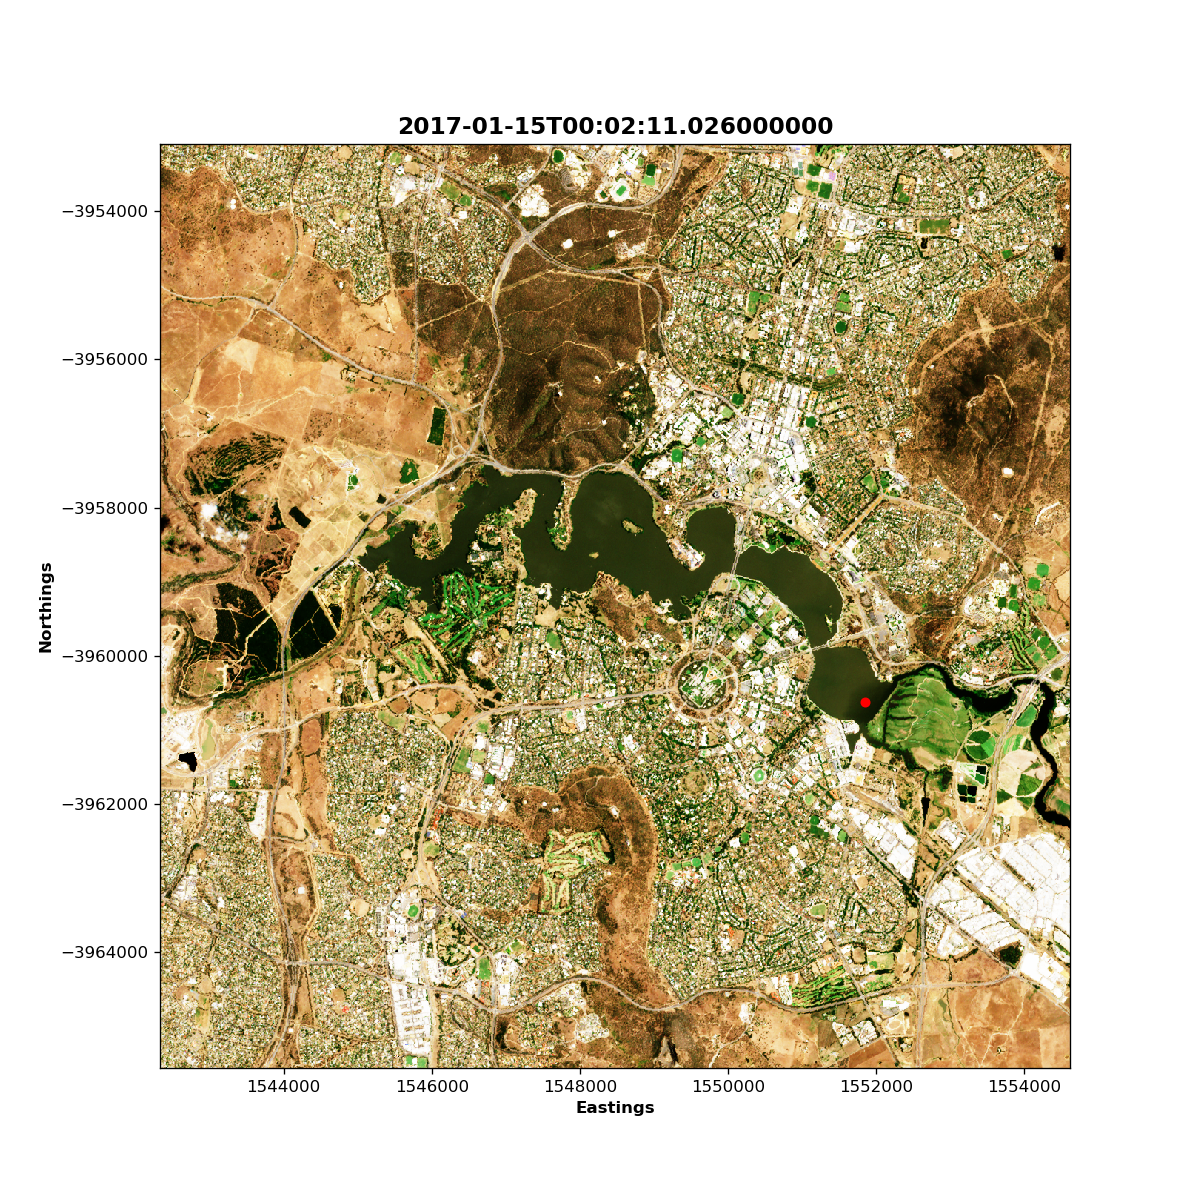

HTML(value='Click on the pixel you would like to interrogate')

In [8]:
print('\033[1m' + 'Click on the pixel you would like to interrogate' + '\033[0m')

DEAPlotting.three_band_image(Resolution10m, bands = ['red', 'green', 'blue'], time = mytime, contrast_enhance=True)

fig = plt.gcf()
w = widgets.HTML("Click on the pixel you would like to interrogate")

cid = fig.canvas.mpl_connect('button_press_event', onclick)
display(w)

## Now plot up the full spectra for that pixel

<IPython.core.display.Javascript object>


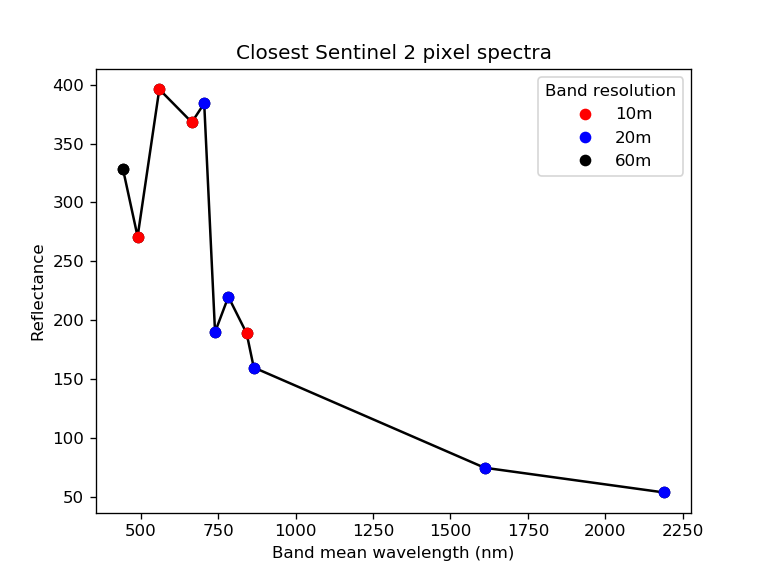

In [9]:
fig = plt.figure()

plt.plot(wavelengths, spectra, 'ko-', label='_nolegend_')
plt.plot((list(wavelengths[i] for i in [1, 2, 3, 7])),
         (list(spectra[i] for i in [1, 2, 3, 7])), 'ro')
plt.plot((list(wavelengths[i] for i in [4, 5, 6, 8, 9, 10])),
         (list(spectra[i] for i in [4, 5, 6, 8, 9, 10])), 'bo')
plt.plot((list(wavelengths[i] for i in [0])),
         (list(spectra[i] for i in [0])), 'ko')

plt.xlabel('Band mean wavelength (nm)')
plt.ylabel('Reflectance')
plt.legend(['10m', '20m', '60m'], title='Band resolution')
plt.title('Closest Sentinel 2 pixel spectra');

## Explore the spectral variability within pixels at different resolutions

<IPython.core.display.Javascript object>


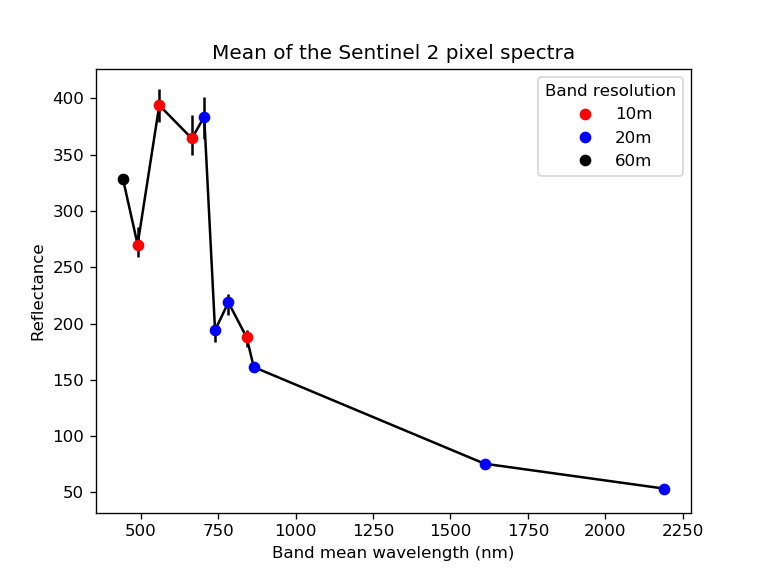

In [10]:
fig = plt.figure()
plt.errorbar(wavelengths, spectramean, 
             yerr = [[i - j for i, j in zip(spectramean, spectramin)], 
                     [j - i for i, j in zip(spectramean, spectramax)]], color = 'k', linestyle = '-', zorder = 1)
plt.plot((list(wavelengths[i] for i in [1, 2, 3, 7])),
         (list(spectramean[i] for i in [1, 2, 3, 7])), 'ro', zorder = 2)
plt.plot((list(wavelengths[i] for i in [4, 5, 6, 8, 9, 10])),
         (list(spectramean[i] for i in [4, 5, 6, 8, 9, 10])), 'bo', zorder = 3)
plt.plot((list(wavelengths[i] for i in [0])),
         (list(spectramean[i] for i in [0])), 'ko', zorder = 4)

plt.xlabel('Band mean wavelength (nm)')
plt.ylabel('Reflectance')
plt.legend(['10m', '20m', '60m'], title='Band resolution')
plt.title('Mean of the Sentinel 2 pixel spectra');